In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [7]:
ask_file_path = r'/root/workspace/Autoformer/dataset/forex/EURUSD_Candlestick_1_M_ASK_07.07.2020-07.07.2023.csv'
ask_dataset = pd.read_csv(ask_file_path)

bid_file_path = r'/root/workspace/Autoformer/dataset/forex/EURUSD_Candlestick_1_M_BID_07.07.2020-07.07.2023.csv'
bid_dataset = pd.read_csv(bid_file_path)

In [8]:
ask_dataset

,Gmt time,Open,High,Low,Close,Volume
0,08.07.2020 00:00:00.000,1.12747,1.12751,1.12718,1.12731,96.97
1,08.07.2020 00:01:00.000,1.12731,1.12746,1.12726,1.12743,80.09
2,08.07.2020 00:02:00.000,1.12743,1.12744,1.12723,1.12734,91.98
3,08.07.2020 00:03:00.000,1.12733,1.12734,1.12731,1.12734,23.14
4,08.07.2020 00:04:00.000,1.12734,1.12755,1.12734,1.12755,65.26
...,...,...,...,...,...,...
1126310,07.07.2023 20:55:00.000,1.09670,1.09684,1.09670,1.09681,198.90
1126311,07.07.2023 20:56:00.000,1.09681,1.09686,1.09678,1.09686,102.60
1126312,07.07.2023 20:57:00.000,1.09686,1.09700,1.09686,1.09700,19.80
1126313,07.07.2023 20:58:00.000,1.09700,1.09705,1.09700,1.09705,13.50


In [9]:
bid_dataset

,Gmt time,Open,High,Low,Close,Volume
0,08.07.2020 00:00:00.000,1.12745,1.12749,1.12714,1.12728,146.77
1,08.07.2020 00:01:00.000,1.12727,1.12742,1.12723,1.12739,95.04
2,08.07.2020 00:02:00.000,1.12741,1.12741,1.12722,1.12731,99.32
3,08.07.2020 00:03:00.000,1.12729,1.12731,1.12728,1.12730,32.29
4,08.07.2020 00:04:00.000,1.12731,1.12751,1.12730,1.12751,66.65
...,...,...,...,...,...,...
1125710,07.07.2023 20:55:00.000,1.09662,1.09679,1.09662,1.09675,208.53
1125711,07.07.2023 20:56:00.000,1.09673,1.09683,1.09670,1.09681,124.47
1125712,07.07.2023 20:57:00.000,1.09682,1.09682,1.09676,1.09680,25.83
1125713,07.07.2023 20:58:00.000,1.09678,1.09680,1.09676,1.09676,15.30


In [10]:
ask_dataset['Gmt time'] = pd.to_datetime(ask_dataset['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')
bid_dataset['Gmt time'] = pd.to_datetime(bid_dataset['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')

In [11]:
ask_dataset.rename(columns={'Gmt time': 'date'}, inplace=True)
bid_dataset.rename(columns={'Gmt time': 'date'}, inplace=True)


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

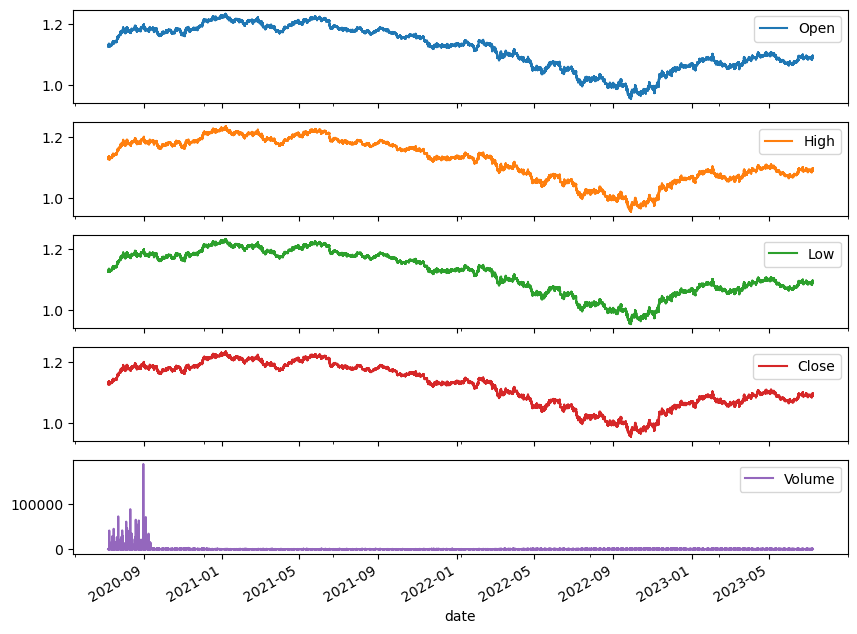

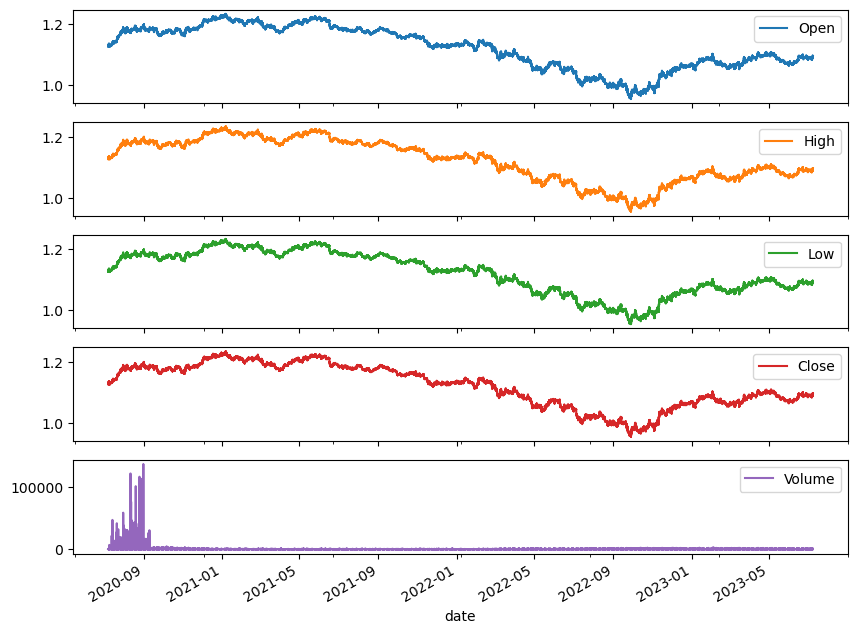

In [12]:
ask_dataset.set_index('date', inplace=True)
bid_dataset.set_index('date', inplace=True)

# Now you can directly use the dataframe for plotting
ask_dataset[['Open', 'High', 'Low', 'Close', 'Volume']].plot(subplots=True)
bid_dataset[['Open', 'High', 'Low', 'Close', 'Volume']].plot(subplots=True)


In [13]:
dataset = pd.merge(bid_dataset, ask_dataset, left_index=True, right_index=True, how='inner', suffixes=('_bid', '_ask'))

In [14]:
dataset

,Open_bid,High_bid,Low_bid,Close_bid,Volume_bid,Open_ask,High_ask,Low_ask,Close_ask,Volume_ask
date,,,,,,,,,,
2020-07-08 00:00:00,1.12745,1.12749,1.12714,1.12728,146.77,1.12747,1.12751,1.12718,1.12731,96.97
2020-07-08 00:01:00,1.12727,1.12742,1.12723,1.12739,95.04,1.12731,1.12746,1.12726,1.12743,80.09
2020-07-08 00:02:00,1.12741,1.12741,1.12722,1.12731,99.32,1.12743,1.12744,1.12723,1.12734,91.98
2020-07-08 00:03:00,1.12729,1.12731,1.12728,1.12730,32.29,1.12733,1.12734,1.12731,1.12734,23.14
2020-07-08 00:04:00,1.12731,1.12751,1.12730,1.12751,66.65,1.12734,1.12755,1.12734,1.12755,65.26
...,...,...,...,...,...,...,...,...,...,...
2023-07-07 20:55:00,1.09662,1.09679,1.09662,1.09675,208.53,1.09670,1.09684,1.09670,1.09681,198.90
2023-07-07 20:56:00,1.09673,1.09683,1.09670,1.09681,124.47,1.09681,1.09686,1.09678,1.09686,102.60
2023-07-07 20:57:00,1.09682,1.09682,1.09676,1.09680,25.83,1.09686,1.09700,1.09686,1.09700,19.80


In [15]:
dataset['Spread'] = dataset['Close_ask'] - dataset['Close_bid']


In [16]:
dataset

,Open_bid,High_bid,Low_bid,Close_bid,Volume_bid,Open_ask,High_ask,Low_ask,Close_ask,Volume_ask,Spread
date,,,,,,,,,,,
2020-07-08 00:00:00,1.12745,1.12749,1.12714,1.12728,146.77,1.12747,1.12751,1.12718,1.12731,96.97,0.00003
2020-07-08 00:01:00,1.12727,1.12742,1.12723,1.12739,95.04,1.12731,1.12746,1.12726,1.12743,80.09,0.00004
2020-07-08 00:02:00,1.12741,1.12741,1.12722,1.12731,99.32,1.12743,1.12744,1.12723,1.12734,91.98,0.00003
2020-07-08 00:03:00,1.12729,1.12731,1.12728,1.12730,32.29,1.12733,1.12734,1.12731,1.12734,23.14,0.00004
2020-07-08 00:04:00,1.12731,1.12751,1.12730,1.12751,66.65,1.12734,1.12755,1.12734,1.12755,65.26,0.00004
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-07 20:55:00,1.09662,1.09679,1.09662,1.09675,208.53,1.09670,1.09684,1.09670,1.09681,198.90,0.00006
2023-07-07 20:56:00,1.09673,1.09683,1.09670,1.09681,124.47,1.09681,1.09686,1.09678,1.09686,102.60,0.00005
2023-07-07 20:57:00,1.09682,1.09682,1.09676,1.09680,25.83,1.09686,1.09700,1.09686,1.09700,19.80,0.00020


In [17]:
dataset.fillna(method='ffill', inplace=True)

In [18]:
# Only keep rows where the day of the week is less than 5 (0 is Monday, 6 is Sunday)
dataset = dataset[dataset.index.weekday < 5]

In [19]:
dataset.to_csv('/root/workspace/Autoformer/dataset/forex/Preprocessed_EURUSD_Candlestick_1_M_ASKBID_07.07.2020-07.07.2023.csv')